In [1]:
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
import tensorflow as tf
from tensorflow.keras.models import load_model
from data_process import getfeature,data_resize
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [2]:
def get_component(X):
    svd = np.linalg.svd(X)
    y = svd[1].reshape(len(svd[1]),1)
    x = np.linspace(0,X.shape[0]-1,X.shape[0]).reshape(X.shape[0],1)
    model = LinearRegression()
    model = model.fit(x[12:,:], y[12:,:])
    y2 = model.predict(x)
    plt.scatter(x, y, c = 'r',marker='.',label = 'raw')
    plt.plot(x,y2,c = 'b',label = 'Regression')
    plt.xlabel('Number of component')
    plt.ylabel('Eigenvalues')
    plt.legend()
    c = max([i for i in range(12) if y[i] > y2[i]])
    return c

def TPR(y_true,y_pred): 
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision=TP/(TP+FN)
    return precision

def FPR(y_true,y_pred): 
    TP=tf.reduce_sum(y_true*tf.round(y_pred))
    TN=tf.reduce_sum((1-y_true)*(1-tf.round(y_pred)))
    FP=tf.reduce_sum((1-y_true)*tf.round(y_pred))
    FN=tf.reduce_sum(y_true*(1-tf.round(y_pred)))
    precision=FP/(TN+FP)
    return precision

def data_transform(data):
    data = list(data)
    data[0] = list(data[0])
    data[1] = np.array(data[1])
    data[2] = list(data[2])
    data[2] = [np.array(i) for i in data[2]]
    data[3] = list(data[3])
    return data

def get_kpic_roi(pics):
    rois = []
    for pic in pics:
        p = pic[2]
        roi = [list(i[:,1]) for i in p]
        rois.append(roi)
    return rois

def model_process(model,pics):
    result = []
    roi= pics[0]
    for roi in pics:
        intensity = [data_resize(i,256) for i in roi]
        intensity2 = np.array(intensity)
        feature = getfeature(roi)
        feature2 = np.array(feature)
        r = np.round(model.predict([intensity2,feature2]))
        r= [index+1 for index,value in enumerate(r) if value == 0]
        r = r[::-1]
        result.append(r)
    return result

In [3]:
#Import the functions in KPIC2 to implement the whole process of metabolomics processing
numpy2ri.activate()
robjects.r('''source('R/kpic_process.R')''')
kpic_pic = robjects.globalenv['kpic_pic']
kpic_pic_set = robjects.globalenv['kpic_pic_set']
kpic_pic_getpeak = robjects.globalenv['kpic_pic_getpeak']
kpic_group = robjects.globalenv['kpic_group']
kpic_iso = robjects.globalenv['kpic_iso']
kpic_mat = robjects.globalenv['kpic_mat']
kpic_fill = robjects.globalenv['kpic_fill']
kpic_pattern = robjects.globalenv['kpic_pattern']
kpic_select = robjects.globalenv['kpic_select']

In [4]:
#Extract PICS using KPIC2
filename = 'E:/evaluation/MTBLS120/pos'
pics = kpic_pic_set(filename,level = 5000)

In [5]:
#Load dffROI and use dffROI prediction to get false positive PICs
pics2 = list(pics)
pics3 = [data_transform(i) for i in pics2]
pics4 = get_kpic_roi(pics3)
_custom_objects = {"TPR":TPR, "FPR":FPR}
dffROI_model = load_model('D:/code/evaluation/dffROI.h5',custom_objects=_custom_objects)
result = model_process(dffROI_model,pics4)

In [6]:
#Filter false positive PICs
del_list = []
for d in range(len(result)):
    d0 = kpic_select(result[d],pics2[d])
    del_list.append(d0)
del_rlist = robjects.ListVector([(str(i), x) for i, x in enumerate(del_list)])

In [7]:
#Extract features on PICs
del_rlist = kpic_pic_getpeak(del_rlist)

In [8]:
#The peak table is obtained by processing the features using methods such as grouping, align, isotope removal, and missing value filling in KPIC2
groups_align = kpic_group(del_rlist)
groups_align = kpic_iso(groups_align)
data = kpic_mat(groups_align)
data = kpic_fill(data)
data = list(data)
data[3] = np.array(data[3])
df = np.array(data[3])

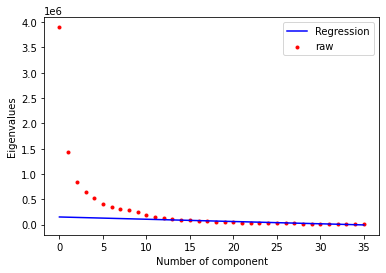

In [16]:
#Data set partitioning for PLS-DA modeling and determining the number of principal components
X = df[6:,:]
y1 = np.zeros((9,1))
y2 = 1*np.ones((9,1))
y3 = 2*np.ones((9,1))
y4 = 3*np.ones((9,1))
y = np.vstack((y1,y2,y3,y4))
Y = y.ravel()
Y = pd.get_dummies(Y)
train_X,test_X, train_y, test_y = train_test_split(X,  Y, test_size=0.3)
n_components = get_component(X)

<AxesSubplot:>

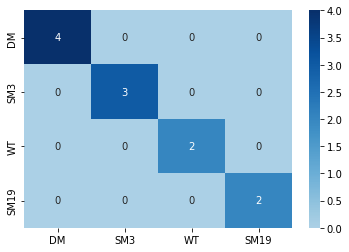

In [17]:
#Build the PLS-DA model and test the model performance on the test set. The results are displayed with a confusion matrix
model = PLSRegression(n_components)
model.fit(train_X,train_y)
y_pred = model.predict(test_X)
y_pred = np.array([np.argmax(i) for i in y_pred])
test_y = np.array([np.argmax(test_y.iloc[i,:]) for i in range(test_y.shape[0])])
yp = model.predict(X)
yp = np.array([np.argmax(i) for i in yp])
yt = y.ravel()  
test_mat = confusion_matrix(test_y,y_pred,labels=[0,1,2,3])
test_mat = pd.DataFrame(test_mat)
test_mat.columns = ['DM','SM3','WT','SM19']
test_mat.index = ['DM','SM3','WT','SM19']
sns.heatmap(test_mat,annot=True,center = 1,cmap="Blues")

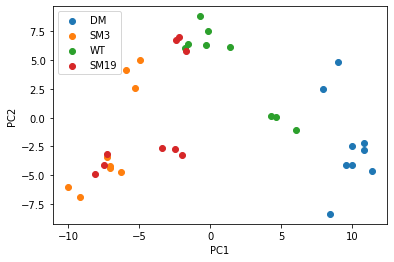

In [18]:
#Plot the principal component dimensionality reduction graph
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(scale(X))
plt.scatter(X_pca[0:9,0], X_pca[0:9,1],label = 'DM')
plt.scatter(X_pca[9:18,0], X_pca[9:18,1],label = 'SM3')
plt.scatter(X_pca[18:27,0], X_pca[18:27,1],label = 'WT')
plt.scatter(X_pca[27:36,0], X_pca[27:36,1],label = 'SM19')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()